In [1]:

from bokeh.plotting import figure, show
from bokeh.palettes import Turbo256
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper
import plotly.express as px
import numpy as np
import pandas as pd
from bokeh.io import output_notebook
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

output_notebook()

def embedding_plotter(embedding, data=None, hue=None, hover=None):
    '''
    Рисовалка эмбеддинга. 2D renderer: bokeh. 3D renderer: plotly.
    '''
    if embedding.shape[1] not in [2, 3]:
        raise ValueError("Embedding must be 2D or 3D")

    plot_data = pd.DataFrame()
    plot_data['x'] = embedding[:, 0]
    plot_data['y'] = embedding[:, 1]

    if embedding.shape[1] == 3:
        plot_data['z'] = embedding[:, 2]

    if hover is not None:
        if isinstance(hover, str):
            hover = [hover]
        for col in hover:
            if data is not None:
                plot_data[col] = data[col].values

    if embedding.shape[1] == 2:
        p = figure(width=800, height=600, tools=['pan', 'box_zoom', 'reset'])

        if hue is not None and data is not None:
            # Непрерывная цветовая палитра
            color_mapper = LinearColorMapper(palette=Turbo256,
                                          low=data[hue].min(),
                                          high=data[hue].max())

            source = ColumnDataSource({
                'x': plot_data['x'],
                'y': plot_data['y'],
                'hue': data[hue]
            })

            if hover:
                for col in hover:
                    source.data[col] = data[col].values

            p.scatter('x', 'y',
                     source=source,
                     size=0.5,
                     color={'field': 'hue', 'transform': color_mapper},
                     alpha=0.6)

            color_bar = ColorBar(color_mapper=color_mapper,
                               label_standoff=12,
                               title=hue)
            p.add_layout(color_bar, 'right')

            if hover:
                tooltips = [(col, '@' + col) for col in hover]
                tooltips.append((hue, '@hue'))
                hover_tool = HoverTool(tooltips=tooltips)
                p.add_tools(hover_tool)

        else:
            p.scatter(plot_data['x'], plot_data['y'], size=0.5, alpha=0.6)

            if hover:
                tooltips = [(col, '@' + col) for col in hover]
                hover_tool = HoverTool(tooltips=tooltips)
                p.add_tools(hover_tool)

        show(p)

    # 3D
    else:
        if hue is not None and data is not None:
            fig = px.scatter_3d(plot_data, x='x', y='y', z='z',
                              color=data[hue],
                              hover_data=hover if hover else None)
        else:
            fig = px.scatter_3d(plot_data, x='x', y='y', z='z',
                              hover_data=hover if hover else None)

        fig.update_layout(
            width=800,
            height=600,
        )


        fig.show()
def representative_point_idx(df):
        points = df.select(pl.col("X", "Y")).to_numpy()
        median = hdm.geomedian(points, axis = 0)
        dists = np.linalg.norm(points - median, axis=1)
        return np.argmin(dists)
import sklearn.cluster as clu

from IPython.display import display, HTML

Loading BokehJS ...

To generate UMAP files from `hexanes_rwp5_constr.cor` run

``` 
 rmsd-map-distances -o hexanes_rwp5_constr hexanes_rwp5_constr.cor
 rmsd-map-umaps -o hexanes_rwp5_constr_umaps hexanes_rwp5_constr.npz
 rmsd-map-umaps -d -o hexanes_rwp5_constr_umaps_d hexanes_rwp5_constr.npz
```

In [2]:
# !rmsd-map-distances -o ./no2/no2cl_constr_proper -k proper ./no2/no2cl.cor

In [3]:
# !rmsd-map-umaps -o ./no2/no2cl_constr_umaps ./no2/no2cl_constr.npz
# !rmsd-map-umaps -d -o ./no2/no2cl_constr_umaps_d ./no2/no2cl_constr.npz

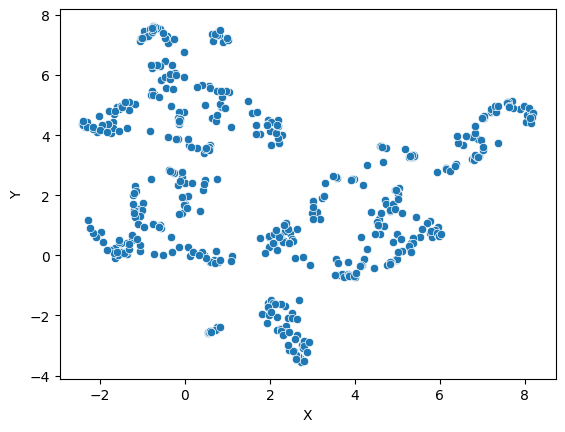

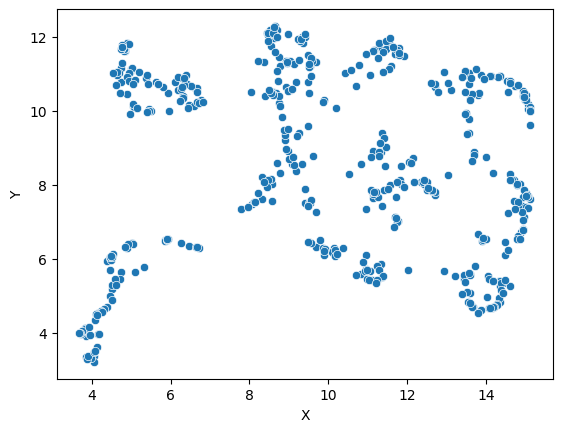

In [11]:
import rmsd_map
from rmsd_map.mol_io.cor_reader import read_cor_file
from rmsd_map.mol_io.fragment import Fragment
from rmsd_map.rmsd.pipelines import align_fragments, partial_align_fragments
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
cor = read_cor_file("./no2/no2cl.cor")
cor = np.asarray(cor, dtype=object)
um = pl.read_csv("./no2/no2cl_constr_umaps_proper.csv") # Vanilla UMAP
ud = pl.read_csv("./no2/no2cl_constr_umaps_d_proper.csv") # Denity-preserving UMAP 
ud_old = pl.read_csv("./no2/no2cl_constr_umaps_d.csv") # Denity-preserving UMAP 



df = ud.filter(pl.col("N") == 10)
sns.scatterplot(data = df , x="X", y="Y")
plt.show()
df_old = ud_old.filter(pl.col("N") == 10)
sns.scatterplot(data = df_old , x="X", y="Y")
plt.show()

def get_c_cl_bond_indices(fragment):
    """
    Find atom indices involved in C-Cl bonds in a fragment.
    Returns a numpy array of atom indices (both C and Cl atoms in C-Cl bonds).
    Ensures C-Cl...Cl-C bonds are aligned to the same positions.
    """
    mol = fragment.mol()
    c_cl_bonds = []
    for bond in mol.GetBonds():
        begin_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx())
        end_atom = mol.GetAtomWithIdx(bond.GetEndAtomIdx())
        # Check if this is a C-Cl bond (either direction)
        if (begin_atom.GetSymbol() == 'C' and end_atom.GetSymbol() == 'Cl') or \
           (begin_atom.GetSymbol() == 'Cl' and end_atom.GetSymbol() == 'C'):
            # Store as (C_idx, Cl_idx) for consistent ordering
            if begin_atom.GetSymbol() == 'C':
                c_cl_bonds.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
            else:
                c_cl_bonds.append((bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()))
    
    # Sort bonds by C atom index for consistent ordering
    c_cl_bonds.sort(key=lambda x: x[0])
    
    # Flatten to get all atom indices: [C1, Cl1, C2, Cl2, ...]
    c_cl_indices = []
    for c_idx, cl_idx in c_cl_bonds:
        c_cl_indices.append(c_idx)
        c_cl_indices.append(cl_idx)
    
    return np.array(c_cl_indices, dtype=int)


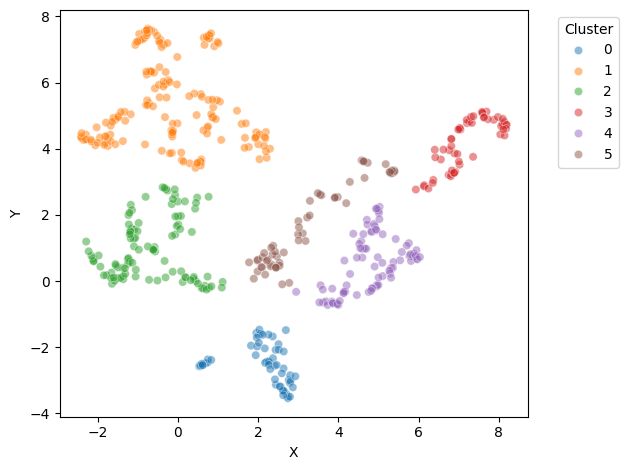

In [15]:

import sklearn.cluster as clu
import matplotlib.pyplot as plt

dbscan = clu.HDBSCAN(min_cluster_size=25,
    min_samples=5,
    cluster_selection_epsilon=0.1,
    metric='euclidean').fit(df.select(pl.col("X", "Y")).to_numpy())
df2 = df.with_columns(pl.Series("label", dbscan.labels_))

sns.scatterplot(data = df2, x = 'X', y = 'Y', hue = 'label', palette='tab10', alpha = 0.5)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# from umap import UMAP  # pyright: ignore[reportUnusedImport, reportUnusedImport]

# import warnings
# warnings.filterwarnings('ignore')

# with np.load('./phcl/phcl_constr_proper.npz') as data:
#         names = data['names']
#         distances = data["distances"]


# reducer = UMAP(metric='precomputed',
#                    n_neighbors=40,
#                    densmap=True,!rmsd-map-umaps -o ./no2/no2cl_constr_umaps ./no2/no2cl_constr.npz
# !rmsd-map-umaps -d -o ./no2/no2cl_constr_umaps_d ./no2/no2cl_constr.npz
# reducer.fit(distances)
# df = pl.DataFrame(reducer.embedding_, schema=["X", "Y", 'Z'])
# df = df.with_columns(pl.lit(30).alias("N"))


# dbscan = clu.HDBSCAN(min_cluster_size=30,
#     min_samples=15,
#     cluster_selection_epsilon=0.5,
#     metric='euclidean').fit(df.select(pl.col("X", "Y", "Z")).to_numpy())
# df2 = df.with_columns(pl.Series("label", dbscan.labels_))


# embedding = df2.select(pl.col("X", "Y", "Z")).to_numpy()

# embedding_plotter(
#     embedding,
#     data=df2.to_pandas(),
#     hue='label',
#     hover = ['label']
# )


In [16]:
for i in df2["label"].unique():
    # Convert Polars boolean Series to numpy array for indexing
    mask = (df2["label"] == i).to_numpy()
    clu0_all = cor[mask]
    # Sample 100 elements (or all if less than 100)
    n_samples = min(500, len(clu0_all))
    # print(clu0_all)
    if n_samples > 0 and len(clu0_all) > 0:
        sample_indices = np.random.choice(len(clu0_all), size=n_samples, replace=False)
        clu0 = clu0_all[sample_indices]
    else:
        clu0 = clu0_all
    clu0_center_idx = 0 # find a central point on umap
    # Get C-Cl bond atom indices from the reference fragment
    # This finds all C-Cl bonds (C-Cl-Cl-C pattern) and returns indices in order: [C1, Cl1, C2, Cl2]
    c_cl_indices = get_c_cl_bond_indices(clu0[clu0_center_idx])
    # Align all fragments so their C-Cl-Cl-C bonds match the reference fragment's C-Cl bond positions
    clu0_aligned = partial_align_fragments(clu0, c_cl_indices, n_center=1)
    # print(clu0_aligned)
    # clu0_aligned = align_fragments(clu0, 0)
    print(f'Cluster {i} has {len(clu0_aligned)} fragments (sampled from {len(clu0_all)})')
    clu0_view = Fragment.plot_fragments(clu0_aligned)
    display(HTML(clu0_view.write_html(fullpage=True)))


Cluster 0 has 58 fragments (sampled from 58)


Cluster 1 has 157 fragments (sampled from 157)


Cluster 2 has 103 fragments (sampled from 103)


Cluster 3 has 57 fragments (sampled from 57)


Cluster 4 has 82 fragments (sampled from 82)


Cluster 5 has 57 fragments (sampled from 57)
